Converged at T_max = 50.16722408026756 with change norm = 4.81e-09


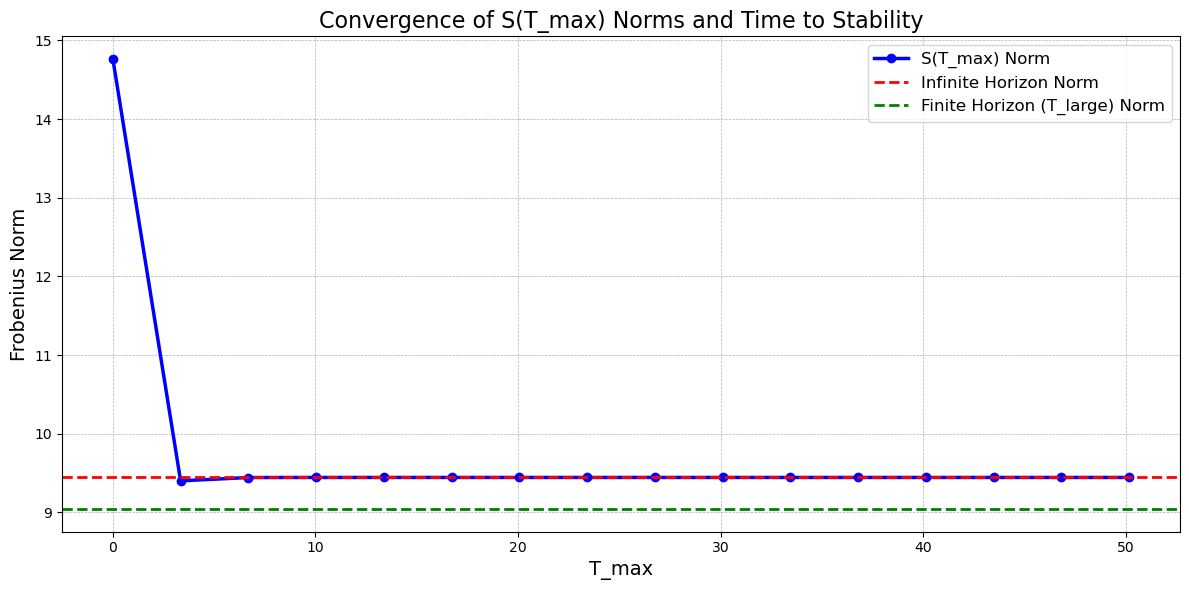

Finite Horizon Solution (Large T):
 tensor([[ 4.6328, -1.7981],
        [-1.7981,  7.3353]], dtype=torch.float64)
Infinite Horizon Solution:
 tensor([[ 4.8753, -2.3767],
        [-2.3767,  7.3572]], dtype=torch.float64)
Difference between finite and infinite horizon solutions: 0.8537551535789404


In [4]:
import torch
import numpy as np
from scipy.integrate import solve_ivp
from scipy.linalg import solve_continuous_are, LinAlgError
import matplotlib.pyplot as plt

class SoftLQR:
    def __init__(self, H, M, C, D, R, sigma, time_grid):
        self.H = H.numpy()
        self.M = M.numpy()
        self.C = C.numpy()
        self.D = D.numpy()
        self.R = R.numpy()
        self.sigma = sigma.numpy()
        self.time_grid = time_grid.numpy()
        self.solution_finite = None
        self.solution_infinite = None
        self.solution_history = []  # To store S(t) at each step
        self.stability_results = []
        self.tau = None
        self.gamma = None
        self.T_max= None
        self.T_in = None
        
        

    def solve_ricatti_finite(self, time_grid, tau, gamma):
        
        
        self.tau = tau
        self.gamma = gamma
        self.solution_history.clear()
        
        self.T_max= time_grid[-1]
        self.T_in= time_grid[0] 
        self.delta_t = time_grid[1] - time_grid[0] 

        def riccati_rhs(t, S_flat):
            S = S_flat.reshape(self.R.shape)
            gamma_adjust = tau / (2 * gamma ** 2)
            try:
                regularization = np.eye(self.D.shape[0]) * 1e-8
                inverse_term = np.linalg.inv(self.D + gamma_adjust * np.eye(self.D.shape[0]) + regularization)
            except LinAlgError:
                raise RuntimeError("Matrix inversion failed due to singular matrix.")

            S_dot = -(self.H.T @ S + S @ self.H + self.C - S.T @ self.M @ inverse_term @ self.M.T @ S)
            return S_dot.ravel()

        S_initial = self.R.ravel()
        try:
            sol = solve_ivp(riccati_rhs, [self.T_max, self.T_in], S_initial, method='BDF',
                            t_eval=np.linspace(self.T_max, self.T_in, len(time_grid)),
                            max_step=10.0, atol=1e-4, rtol=1e-3)

            if sol.success:
                for i in range(sol.y.shape[1]):
                    self.solution_history.append(sol.y[:, i].reshape(self.R.shape))
                self.solution_finite = torch.from_numpy(sol.y[:, -1].reshape(self.R.shape))
                
            else:
                raise RuntimeError(f"Riccati ODE Solver failed: {sol.message}")

        except Exception as e:
            print(f"Error solving Riccati ODE: {e}")

    def solve_ricatti_infinite(self, tau, gamma):
        Q = self.C
        A = self.H
        B = self.M
        gamma_adjust = tau / (2 * gamma ** 2)
        try:
            S_ss = solve_continuous_are(A, B, Q, self.D + gamma_adjust * np.eye(self.D.shape[0]))
            self.solution_infinite = torch.from_numpy(S_ss)
        except LinAlgError:
            raise RuntimeError("Singular matrix encountered during CARE solution.")

    def integrate_until_stability_progressive(self, tol=1e-8, tau=0.1, gamma=0.1):
        self.stability_results = []
        max_tims = np.linspace(0, 1000, num=300)
        converged = False

        for T_max in max_tims:
            if converged:
                break

            def riccati_rhs(t, S_flat):
                S = S_flat.reshape(self.R.shape)
                gamma_adjust = tau / (2 * gamma ** 2)
                try:
                    regularization = np.eye(self.D.shape[0]) * 1e-8
                    inverse_term = np.linalg.inv(self.D + gamma_adjust * np.eye(self.D.shape[0]) + regularization)
                except LinAlgError:
                    raise RuntimeError("Matrix inversion failed due to singular matrix.")

                S_dot = -(self.H.T @ S + S @ self.H + self.C - S.T @ self.M @ inverse_term @ self.M.T @ S)
                return S_dot.ravel()

            S_initial = self.R.ravel()
            try:
                sol = solve_ivp(riccati_rhs, [T_max, 0], S_initial, method='BDF',
                                dense_output=True, max_step=10.0, atol=1e-5, rtol=1e-3)

                if sol.success:
                    final_state = sol.y[:, -1].reshape(self.R.shape)
                    final_norm = np.linalg.norm(final_state, ord='fro')
                    self.stability_results.append((T_max, final_norm))

                    if len(self.stability_results) > 1:
                        previous_norm = self.stability_results[-2][1]
                        if abs(previous_norm - final_norm) < tol:
                            print(f"Converged at T_max = {T_max} with change norm = {abs(previous_norm - final_norm):.2e}")
                            converged = True
                            break

            except Exception as e:
                print(f"Error during stability integration for T_max={T_max}: {e}")

        if not converged:
            print("Did not converge within the specified range.")

        plt.figure(figsize=(12, 6))  # Larger figure size for better visibility
        if self.stability_results:
            times, norms = zip(*self.stability_results)
            plt.plot(times, norms, marker='o', linestyle='-', color='blue', linewidth=2.5, label='S(T_max) Norm')

        if self.solution_infinite is not None:
            infinite_norm = np.linalg.norm(self.solution_infinite.numpy(), ord='fro')
            plt.axhline(y=infinite_norm, color='r', linestyle='--', linewidth=2, label='Infinite Horizon Norm')

        if self.solution_finite is not None:
            finite_norm = np.linalg.norm(self.solution_finite.numpy(), ord='fro')
            plt.axhline(y=finite_norm, color='g', linestyle='--', linewidth=2, label='Finite Horizon (T_large) Norm')

        plt.xlabel('T_max', fontsize=14)
        plt.ylabel('Frobenius Norm', fontsize=14)
        plt.title('Convergence of S(T_max) Norms and Time to Stability', fontsize=16)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.tight_layout()
        plt.show()

    def compare_solutions(self):
        if self.solution_finite is None or self.solution_infinite is None:
            raise ValueError("Solutions have not been computed.")

        print("Finite Horizon Solution (Large T):\n", self.solution_finite)
        print("Infinite Horizon Solution:\n", self.solution_infinite)

        difference = torch.norm(self.solution_finite - self.solution_infinite, p='fro')
        print(f"Difference between finite and infinite horizon solutions: {difference.item()}")

    def get_S_at_time(self, t):
        if not self.solution_history:
            raise ValueError("Solutions have not been computed. Please run `solve_ricatti_finite` first.")

        closest_time_index = np.argmin(np.abs(self.time_grid - t))
        return self.solution_history[closest_time_index]

    def calculate_trace_integral_simpson(self, start_index):
        trace_integral = 0
        n = len(self.solution_history)

        if (n - start_index) < 2:
            raise ValueError("Insufficient points for Simpson's method; need at least 2 points.")

        if (n - start_index - 1) % 2 != 0:
            end_index = n
        else:
            end_index = n - 1

        dt = self.time_grid[1] - self.time_grid[0]

        for i in range(start_index, end_index - 1, 2):
            S_i = self.solution_history[i]
            S_ip1 = self.solution_history[i + 1]
            S_ip2 = self.solution_history[i + 2]

            trace_i = np.trace(self.sigma @ self.sigma.T @ S_i)
            trace_ip1 = np.trace(self.sigma @ self.sigma.T @ S_ip1)
            trace_ip2 = np.trace(self.sigma @ self.sigma.T @ S_ip2)

            trace_integral += (trace_i + 4 * trace_ip1 + trace_ip2) * dt / 3

        return trace_integral

    def calculate_control_problem_value(self, t, x):
        S_t = self.get_S_at_time(t)

        x_np = x.numpy()
        quadratic_term = np.dot(x_np.T, np.dot(S_t, x_np))

        m = S_t.shape[0]
        gamma_adjust = self.tau / (2 * self.gamma ** 2)
        inverse_sigma = np.linalg.inv(self.D + gamma_adjust * np.eye(m))
        det_sigma = np.linalg.det(inverse_sigma)
        C_D_tau_gamma = -self.tau * np.log((self.tau ** (m / 2)) / (self.gamma ** m) * np.sqrt(det_sigma))

        start_index = np.argmin(np.abs(self.time_grid - t))
        trace_integral = self.calculate_trace_integral_simpson(start_index)

        v_value = quadratic_term + trace_integral + (self.time_grid[-1] - t) * C_D_tau_gamma
        

        return torch.tensor(v_value)

    def optimal_markov_control(self, time_tensor, space_tensor):
        # Check if Riccati solutions are computed
        if not self.solution_history:
            raise ValueError("Solutions have not been computed. Please run `solve_ricatti_finite` first.")

        # Prepare tensor to store the means and covariances for the normal distributions
        result_control_means = torch.zeros((len(time_tensor), space_tensor.shape[0], space_tensor.shape[1]))
        result_control_variances = torch.zeros((len(time_tensor), space_tensor.shape[1], space_tensor.shape[1]))

        m = self.D.shape[0]
        gamma_adjust = self.tau / (2 * self.gamma ** 2)
        inverse_sigma = np.linalg.inv(self.D + gamma_adjust * np.eye(m))
        
        for idx, t in enumerate(time_tensor):
            # Get S(t) at time t
            S_t = self.get_S_at_time(t.item())  # Item to get Python number from tensor

            for j, x in enumerate(space_tensor):
                # Calculate mean for each control distribution
                x_np = x.numpy()  # Convert to numpy for matrix operations
                control_mean = -inverse_sigma @ self.M.T @ S_t @ x_np
                result_control_means[idx, j] = torch.from_numpy(control_mean)
                

            # Calculate variance (covariance matrix) for each control distribution (same for all states at time t)
            control_variance = self.tau * (self.D + gamma_adjust * np.eye(m))
            result_control_variances[idx] = torch.from_numpy(control_variance)

        # Return the means and variances to characterize the normal distribution
        return result_control_means, result_control_variances

# Example usage
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]]) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]])
sigma = torch.eye(2) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]]) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]]) * 10.0
time_grid = torch.linspace(0, 1, 100)


soft_lqr = SoftLQR(H, M, C, D, R, sigma, time_grid)

tau_value = 0.1
gamma_value = 0.1

try:
    soft_lqr.solve_ricatti_finite(time_grid = time_grid , tau=tau_value, gamma=gamma_value)
    soft_lqr.solve_ricatti_infinite(tau=tau_value, gamma=gamma_value)
    soft_lqr.integrate_until_stability_progressive(tol=1e-8, tau=tau_value, gamma=gamma_value)
    soft_lqr.compare_solutions()



except RuntimeError as e:
    print(f"Encountered error during the solution: {e}")
except ValueError as e:
    print(f"Error: {e}")


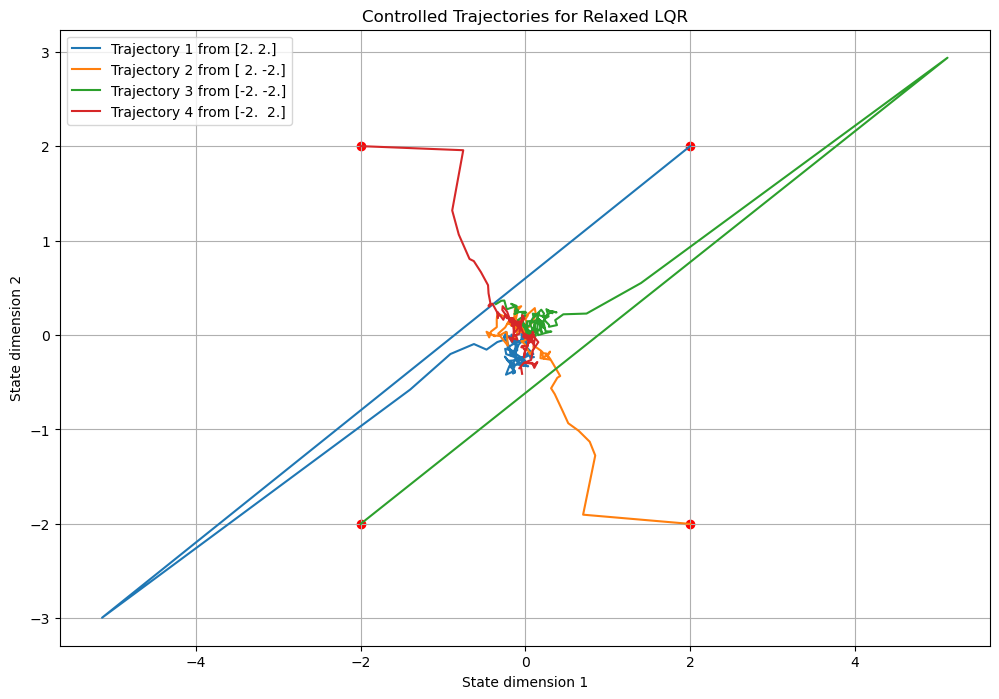

In [5]:
# Initialize parameters for SoftLQR
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32)
sigma = torch.eye(2, dtype=torch.float32) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float32) * 10.0
time_grid = torch.linspace(0, 1, 100, dtype=torch.float32)
tau_value = 0.1
gamma_value = 10.0

# Initialize SoftLQR instance
soft_lqr = SoftLQR(H, M, C, D, R, sigma, time_grid)

# Solve for Riccati equations
try:
    soft_lqr.solve_ricatti_finite(time_grid = time_grid, tau=tau_value, gamma=gamma_value)

    # Define initial conditions
    initial_conditions = [torch.tensor([2.0, 2.0], dtype=torch.float32),
                          torch.tensor([2.0, -2.0], dtype=torch.float32),
                          torch.tensor([-2.0, -2.0], dtype=torch.float32),
                          torch.tensor([-2.0, 2.0], dtype=torch.float32)]

    # Time step for integration
    time_step = time_grid[1].item() - time_grid[0].item()

    # Simulate trajectories
    trajectories = []
    for x_init in initial_conditions:
        x = x_init.clone()
        traj = [x.numpy()]

        for t in time_grid:
            control_means, _ = soft_lqr.optimal_markov_control(torch.tensor([t], dtype=torch.float32), x.unsqueeze(0))
            control_mean = control_means[0, 0].numpy()  # Extract mean control

            # Expected value of control is M multiplied by this mean
            expected_control = M.numpy() @ control_mean

            # Simulate the dynamics using the expected control
            brownian_increment = np.random.normal(0, np.sqrt(time_step), size=x.shape)
            x = x + (H @ x + torch.tensor(expected_control, dtype=torch.float32)) * time_step + sigma.matmul(torch.tensor(brownian_increment, dtype=torch.float32))
            traj.append(x.numpy())

        trajectories.append(np.array(traj))

    # Plot trajectories
    plt.figure(figsize=(12, 8))
    for i, traj in enumerate(trajectories):
        plt.plot(traj[:, 0], traj[:, 1], label=f"Trajectory {i+1} from {initial_conditions[i].numpy()}")
        plt.scatter(traj[0, 0], traj[0, 1], marker='o', c='red')  # Initial point

    plt.xlabel('State dimension 1')
    plt.ylabel('State dimension 2')
    plt.title('Controlled Trajectories for Relaxed LQR')
    plt.legend()
    plt.grid(True)
    plt.show()

except RuntimeError as e:
    print(f"Encountered error during the solution: {e}")
except ValueError as e:
    print(f"Error: {e}")


In [6]:
#EDIT *********
class StrLQR:
    def __init__(self, H, M, C, D, R, sigma,T,N):
        
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.T = T
        self.N = N
        
        self.time_grid = torch.linspace(0, T, N)

        self.S = torch.zeros((N, 2, 2)) 

    def Riccati_ode(self, t, S_flat):
        
        M = self.M.detach().numpy()
        D = self.D.detach().numpy()
        H = self.H.detach().numpy()
        C = self.C.detach().numpy()

        # Reshape S_flat to 2x2 matrix
        S = S_flat.reshape(2, 2)

        # Riccati ODE
        dS = (S @ M @ np.linalg.inv(D) @ M.T @ S) - (H.T @ S) - (S @ H) - C

        # Return the flatten version of dS since solve_ivp requires a vector
        return dS.flatten()
    
    def solve_ricatti_finite(self):
        
        # Flatten the initial condition S(T) = R
        S_T = self.R.flatten().numpy()

        # Solve the Riccati ODE
        S = solve_ivp(self.Riccati_ode, [self.T, 0], S_T, t_eval=np.flip(self.time_grid.numpy()),
                      rtol=1e-9, atol=1e-9) # This is defined in the reversed time grid
    
        sol = np.flip(S.y.T.reshape(self.N, 2, 2)) # Reverse the solution to the original time grid
        self.S = torch.tensor(sol.copy(), dtype=torch.float32) # Store the solution as a tensor

    def calculate_control_problem_value(self, t, x):

        # Solve Riccati ODE if not already solved
        if torch.all(self.S == 0):  
            self.solve_riccati()

        idx = torch.where(self.time_grid <= t)[0][-1]  # Largest index such that time step ≤ t
       
        # Quadratic term x^T S(t) x
        S_t = self.S[idx] # Riccati solution matrix at time step closest to t
        x_col = x.view(2, 1)  
        quad_term = (x_col.T @ S_t @ x_col).item()
        
        # Approximate the integral term using trapezoidal rule
        sigma2 = self.sigma @ self.sigma.T
        integrand = torch.tensor([torch.trace(sigma2 @ S_r) for S_r in self.S[idx:]])

        # integral_term = quad(integrand, t, self.T)
        integral_term = torch.trapezoid(integrand, self.time_grid[idx:], dim=0)
        
        # Value function at t and x
        value = quad_term + integral_term

        return value
    
    def optimal_markov_control(self, t, x):
        
        # Solve Riccati ODE if not already solved
        if torch.all(self.S == 0):  
            self.solve_riccati()

        idx = torch.where(self.time_grid <= t)[0][-1] # Largest index such that time step ≤ t
        S_t = self.S[idx]

        # Optimal control at t and x
        x_col = x.view(2,1) 
        a = -torch.linalg.inv(self.D) @ self.M.T @ S_t @ x_col

        return a


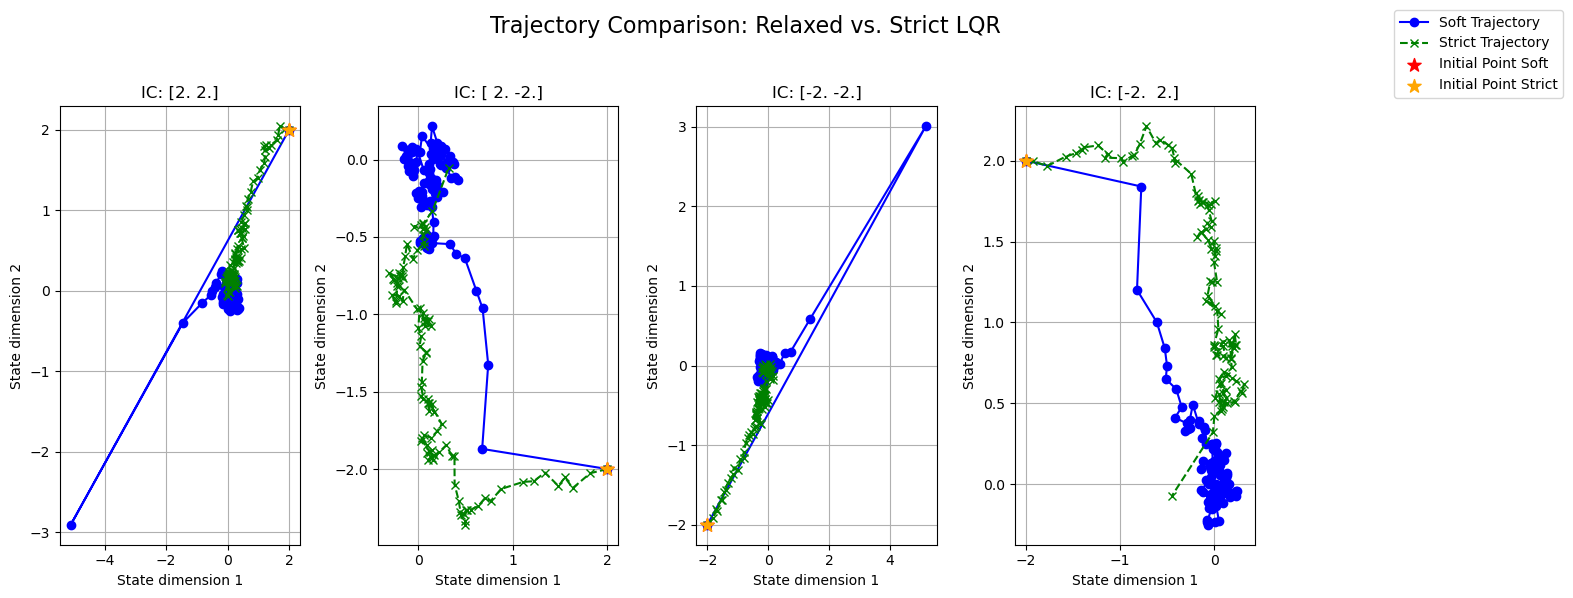

In [7]:
# Initialize parameters
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32) * 0.5
M = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32)
sigma = torch.eye(2, dtype=torch.float32) * 0.5
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32) * 1.0
D = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32) * 0.1
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float32) * 10.0
time_grid = torch.linspace(0, 1, 100, dtype=torch.float32)
T=1
N=100
tau_value = 0.1
gamma_value = 10.0

# Initialize LQR instance
soft_lqr = SoftLQR(H, M, C, D, R, sigma, time_grid)
str_lqr = StrLQR(H, M, C, D, R, sigma,T,N)




# Solve for Riccati equations
try:
    soft_lqr.solve_ricatti_finite(time_grid=time_grid, tau=tau_value, gamma=gamma_value)
    str_lqr.solve_ricatti_finite()
    
    
    # Define initial conditions
    initial_conditions = [torch.tensor([2.0, 2.0], dtype=torch.float32),
                          torch.tensor([2.0, -2.0], dtype=torch.float32),
                          torch.tensor([-2.0, -2.0], dtype=torch.float32),
                          torch.tensor([-2.0, 2.0], dtype=torch.float32)]

    # Time step for integration
    time_step = time_grid[1].item() - time_grid[0].item()

    # Simulate trajectories
    trajectories_Soft = []
    trajectories_Str = []
    for x_init in initial_conditions:
        x1 = x_init.clone()
        x2 = x_init.clone()
        
        traj_Soft = [x1.numpy()]
        traj_Str = [x2.numpy()]

        for t in time_grid:
            control_means, _ = soft_lqr.optimal_markov_control(torch.tensor([t], dtype=torch.float32), x1.unsqueeze(0))
            control_mean = control_means[0, 0].numpy()  # Extract mean control
            expected_control = M.numpy() @ control_mean # Expected value of control is M multiplied by this mean
            
            control_alpha = str_lqr.optimal_markov_control(torch.tensor([t], dtype=torch.float32), x2.unsqueeze(0))
            control_alpha_flat = control_alpha.view(-1)

            
            
            # Simulate the dynamics using the expected control
            brownian_increment = np.random.normal(0, np.sqrt(time_step), size=(2,))
            
            x1 = x1 + (H @ x1 + torch.tensor(expected_control, dtype=torch.float32)) * time_step + sigma.matmul(torch.tensor(brownian_increment, dtype=torch.float32))
            traj_Soft.append(x1.numpy())
            
            
            x2 = x2 + (H @ x2 + M @ control_alpha_flat) * time_step + sigma @ torch.tensor(brownian_increment, dtype=torch.float32)
            traj_Str.append(x2.numpy())

        trajectories_Soft.append(np.array(traj_Soft))
        trajectories_Str.append(np.array(traj_Str))
    
    
    # Create a figure with subplots, one for each initial condition
    num_initial_conditions = len(initial_conditions)
    fig, axs = plt.subplots(1, num_initial_conditions, figsize=(15, 6), squeeze=False)

    for i, (traj_Soft, traj_Str) in enumerate(zip(trajectories_Soft, trajectories_Str)):
        ax = axs[0, i]  # Get the specific subplot
        ax.plot(traj_Soft[:, 0], traj_Soft[:, 1], linestyle='-', marker='o', label='Soft Trajectory', color='blue')
        ax.plot(traj_Str[:, 0], traj_Str[:, 1], linestyle='--', marker='x', label='Strict Trajectory', color='green')

        # Mark the initial points differently for clarity
        ax.scatter(traj_Soft[0, 0], traj_Soft[0, 1], marker='*', c='red', s=100, zorder=5, label='Initial Point Soft')
        ax.scatter(traj_Str[0, 0], traj_Str[0, 1], marker='*', c='orange', s=100, zorder=5, label='Initial Point Strict')

        # Set the title for each subplot
        ax.set_title(f"IC: {initial_conditions[i].numpy()}")

        # Set labels and grid
        ax.set_xlabel('State dimension 1')
        ax.set_ylabel('State dimension 2')
        ax.grid(True)

    # Add a larger legend outside of subplots
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1))

    plt.suptitle('Trajectory Comparison: Relaxed vs. Strict LQR', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
    plt.show()


except RuntimeError as e:
    print(f"Encountered error during the solution: {e}")
except ValueError as e:
    print(f"Error: {e}")


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the LQR Environment with Log Probability
class LQREnvironmentWithPolicy:
    def __init__(self, H, M, C, D, R, sigma, gamma, initial_distribution, T, dt):
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.sigma = sigma
        self.gamma = gamma
        self.initial_distribution = initial_distribution
        self.T = T
        self.dt = dt
        self.device = torch.device('cpu')
        self.current_state = None
        self.N = int(T / dt)
        self.action_dim = M.size(1)

    def sample_initial_state(self):
        self.current_state = self.initial_distribution.to(self.device)
        return self.current_state

    def step(self, action):
        
        action = action.view(-1, 1)
        noise = torch.tensor(np.random.normal(0, np.sqrt(self.dt), size=(2,1)), dtype=torch.float32).to(self.device)
        
        
        # Ensure current_state is a column vector
        current_state_col = self.current_state.unsqueeze(1)

        # Compute new state as a column vector
        new_state_col = current_state_col + (self.H @ current_state_col + self.M @ action) * self.dt + self.sigma @ noise
        new_state = new_state_col.squeeze()

        # Compute costs
        state_cost = (current_state_col.T @ self.C @ current_state_col).item()  # Result should be scalar
        action_cost = (action.T @ self.D @ action).item()  # Result should be scalar
        cost = state_cost + action_cost

        # Update current state to new state
        self.current_state = new_state

        return self.current_state, cost

    def observe_terminal_cost(self):
        return (self.current_state.T @ self.R @ self.current_state).item()

    def f(self, action, t, x):
        xCx = (x.T @ self.C @ x).item()
        aDa = (action.T @ self.D @ action).item()
        return xCx + aDa

    def gaussian_quadratic_integral(self):
        try:
            epsilon = 1e-8  # Small value to ensure non-singularity
            adjusted_matrix = torch.eye(self.action_dim) / (2 * self.gamma**2) - self.D
            adjusted_matrix += torch.eye(self.action_dim) * epsilon  # Adding to diagonal

            precision_matrix = torch.inverse(adjusted_matrix)
            integral_value = torch.sqrt((2 * np.pi) ** self.action_dim * torch.linalg.det(precision_matrix)).item()
        
            return integral_value
        except torch.linalg.LinAlgError as e:
            print("Matrix inversion failed due to singular matrix:", e)
            return float('inf') 

    def fixed_policy_log_prob(self, action, t, state):
        f_atx = self.f(action, t, state)
        integral_value = self.gaussian_quadratic_integral()
        log_denominator = np.log(integral_value)
        log_prob = f_atx - log_denominator
        return log_prob

# Define the Only Linear Value Neural Network
class OnlyLinearValueNN(nn.Module):
    def __init__(self, device=torch.device("cpu")):
        super(OnlyLinearValueNN, self).__init__()
        self.device = device
        self.hidden_layer_width = 512  # Set hidden layer width

        # Define the hidden layer
        self.hidden_layer = nn.Linear(1, self.hidden_layer_width, device=device)

        # Define the matrix and offset layers following the hidden layer
        self.matrix = nn.Linear(self.hidden_layer_width, 2*2, device=device)
        self.offset = nn.Linear(self.hidden_layer_width, 1, device=device)

        # Non-linear activation function
        self.activation = nn.ReLU()

    def forward(self, t):
        # Pass input through the hidden layer and activation
        x = self.activation(self.hidden_layer(t))

        # Calculate the matrix elements and offset
        matrix_elements = self.matrix(x)
        matrix = matrix_elements.view(-1, 2, 2)
        matrix = torch.bmm(matrix, matrix.transpose(1, 2)) + torch.eye(2).to(matrix.device) * 1e-3

        offset = self.offset(x)
        return matrix, offset



In [ ]:
def fixed_policy(t,x):
    
    
    control_means_f,control_variances_f = soft_lqr.optimal_markov_control(torch.tensor([t], dtype=torch.float32), x.unsqueeze(0))
    
    
    mean_sample = control_means_f[0, 0, :]
    cov_sample = control_variances_f[0]
    
    # Create a Normal distribution based on calculated parameters
    normal_dist = torch.distributions.MultivariateNormal(mean_sample, covariance_matrix=cov_sample)

    # Sample an action and return
    action = normal_dist.sample()
    
    return action

In [ ]:
# Critic Algorithm with the environment
def offline_critic_algorithm(env, fixed_policy, num_episodes=501, Δt=0.01, τ=0.5, γcritic=1):
    # Initialize parameter η
    value_nn = OnlyLinearValueNN().to(env.device)
    optimizer = optim.Adam(value_nn.parameters(), lr=1e-3)
    
    for episode in range(num_episodes):
        # Sample initial state X0 ~ ρ
        X0 = env.sample_initial_state()
        X = X0.clone()
        
        costs = []
        states = []
        actions = []
        
        for n in range(env.N):
            t = n * Δt
            states.append((t, X))
            
            # Sample action according to the fixed policy
            α_t = fixed_policy(t, X)
            actions.append(α_t)
            
            
            
            # Apply action and observe cost and new state
            X, f_t = env.step(α_t)
            
            costs.append(f_t)
            
            if n == env.N - 1:
                g_T = env.observe_terminal_cost()
        
        # Compute critic loss L^(η)
        loss = 0.0
        for n in range(env.N):
            t, Xn = states[n]
            predicted_matrix, predicted_offset = value_nn(torch.tensor([t], dtype=torch.float32).to(env.device))
            v_hat = Xn.T @ predicted_matrix @ Xn + predicted_offset.squeeze()
            
            running_cost = sum(costs[k] + τ * env.fixed_policy_log_prob(actions[k], t, Xn) * (Δt) for k in range(n, env.N))
            terminal_adjust = g_T if n == env.N - 1 else 0.0
            
            L_hat = (v_hat - running_cost - terminal_adjust) ** 2
            loss += L_hat

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if episode % 50 == 0:
            print(f"Episode {episode}, Critic Loss: {loss.item()}")

    return value_nn

# Example usage:
H = torch.tensor([[1.0, 1.0], [0.0, 1.0]], dtype=torch.float32) * 0.5
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]], dtype=torch.float32)
C = torch.tensor([[1.0, 0.1], [0.1, 1.0]], dtype=torch.float32)
D = torch.tensor([[1, 0.0], [0.0, 1]], dtype=torch.float32)
R = torch.tensor([[1.0, 0.3], [0.3, 1.0]], dtype=torch.float32) * 10.0
sigma = torch.eye(2, dtype=torch.float32) * 0.5
gamma = 1.0
T = 0.5
dt = 0.005

initial_distribution = torch.FloatTensor(2).uniform_(-2.0, 2.0)


env_policy = LQREnvironmentWithPolicy(H, M, C, D, R, sigma, gamma, initial_distribution, T, dt)


# Train the critic
value_nn = offline_critic_algorithm(env_policy, fixed_policy)


In [ ]:
import torch
import numpy as np
import itertools
import matplotlib.pyplot as plt

value_nn1 = OnlyLinearValueNN(device=torch.device("cpu"))

# Grid definition
t_grid = torch.tensor([0.0, 1/6, 2/6, 0.5], dtype=torch.float32)
x_grid = np.linspace(-3, 3, 100)  # Fine grid for state space evaluation
state_pairs = list(itertools.product(x_grid, x_grid))
num_points = len(state_pairs)

# Compute exact LQR value function
def compute_exact_value(t, x):
    S_t = soft_lqr.get_S_at_time(t.numpy())
    x_np = x
    return np.dot(x_np.T, S_t @ x_np)

# Compute approximate value using neural network
def compute_approximate_value(t, x):
    x_tensor = torch.tensor(x, dtype=torch.float32)
    matrix, offset = value_nn1.forward(t.unsqueeze(0))  # Forward pass for time t
    v_hat = torch.matmul(x_tensor, torch.matmul(matrix.squeeze(0), x_tensor))
    return v_hat.item() + offset.item()

# Calculate errors over the grid
errors = np.zeros((len(t_grid), num_points))
for i, t in enumerate(t_grid):
    for j, (x1, x2) in enumerate(state_pairs):
        x = np.array([x1, x2])
        exact_value = compute_exact_value(t, x)
        approximate_value = compute_approximate_value(t, x)
        errors[i, j] = np.abs(exact_value - approximate_value)

# Display errors
print("Max Error over Grid:", np.max(errors))
print("Mean Error over Grid:", np.mean(errors))


